## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Tuple
import torch.nn.functional as F


## NN

In [2]:
class QuadraticNet(nn.Module):
    """Neural network for learning quadratic functions."""
    def __init__(self, layer_sizes: list[int]):
        super().__init__()
        self.layers = nn.ModuleList()

        # Create linear layers
        for in_features, out_features in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.layers.append(nn.Linear(in_features, out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.relu(layer(x))
        return self.layers[-1](x)
    
class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()
        print(f"Initialized ICNN with {self.act} activation")

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]

## Data

In [3]:
# def generate_data(num_samples: int = 1000, train_ratio: float = 0.8) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
#     """Generate quadratic function data and split into train and evaluation sets."""
#     # x = torch.linspace(-20, 20, num_samples).reshape(-1, 1)
#     x = torch.rand(num_samples).reshape(-1, 1) * 100
#     y = x * 0 + 0.001 *  torch.sin(x)

#     eval_ratio = train_ratio / 2

#     # Split data into train and evaluation sets
#     train_size = int(num_samples * train_ratio)
#     eval_size = int(num_samples * eval_ratio)
    
#     train_x, train_y = x[:train_size], y[:train_size]
#     eval_x, eval_y = x[train_size:], y[train_size:]

#     return train_x, train_y, eval_x, eval_y

def generate_data(num_samples: int = 1000, train_ratio: float = 0.8) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate quadratic function data and split into train and evaluation sets."""
    x = torch.linspace(-30, 30, num_samples).reshape(-1, 1)
    y = x * 0 + 5

    # Split data into train and evaluation sets
    train_size = int(num_samples * train_ratio)
    train_x, train_y = x[:train_size], y[:train_size]
    eval_x, eval_y = x[train_size:], y[train_size:]

    return train_x, train_y, eval_x, eval_y

def normalize_data(x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, StandardScaler, StandardScaler]:
    """Normalize the input and output data."""
    scaler_x, scaler_y = StandardScaler(), StandardScaler()
    x_normalized = torch.FloatTensor(scaler_x.fit_transform(x.numpy()))
    y_normalized = torch.FloatTensor(scaler_y.fit_transform(y.numpy()))
    return x_normalized, y_normalized, scaler_x, scaler_y

def scale_data(x: torch.Tensor, y: torch.Tensor, scaler_x: StandardScaler, scaler_y: StandardScaler) -> Tuple[torch.Tensor, torch.Tensor]:
    """Scale the input and output data using existing scalers."""
    x_normalized = torch.FloatTensor(scaler_x.transform(x.numpy()))
    y_normalized = torch.FloatTensor(scaler_y.transform(y.numpy()))
    return x_normalized, y_normalized

def create_dataloader(x: torch.Tensor, y: torch.Tensor, batch_size: int = 32) -> DataLoader:
    """Create a DataLoader from input tensors."""
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Training and evaluation

In [4]:
def train_model(model: nn.Module, dataloader: DataLoader, num_epochs: int = 1000, lr: float = 0.001) -> nn.Module:
    """Train the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 30 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model

def evaluate_model(model: nn.Module, x: torch.Tensor, scaler_y: StandardScaler) -> torch.Tensor:
    """Evaluate the model and inverse transform the predictions."""
    model.eval()
    with torch.no_grad():
        # x should already be normalized
        y_pred_normalized = model(x)
        y_pred = torch.FloatTensor(scaler_y.inverse_transform(y_pred_normalized.numpy()))
    return y_pred

def plot_results(x: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, plot_title: str):
    """Plot the true function and the model's predictions."""
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='True')
    plt.scatter(x, y_pred, label='Predicted')
    plt.legend()
    plt.title(f'Quadratic Function: True vs Predicted | {plot_title}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [5]:
def run_training():
    # Generate and normalize data
    train_x, train_y, eval_x, eval_y = generate_data()
    train_x_normalized, train_y_normalized, scaler_x, scaler_y = normalize_data(train_x, train_y)
    eval_x_normalized, eval_y_normalized = scale_data(eval_x, eval_y, scaler_x, scaler_y)

    # Create dataloaders
    train_dataloader = create_dataloader(train_x_normalized, train_y_normalized)

    # Initialize and train model
    # model = QuadraticNet()
    model = ICNN([1, 16, 16, 1])
    trained_model = train_model(model, train_dataloader)

    # Evaluate model on train set
    train_y_pred = evaluate_model(trained_model, train_x_normalized, scaler_y)

    # Evaluate model on evaluation set
    eval_y_pred = evaluate_model(trained_model, eval_x_normalized, scaler_y)

    # Plot results
    plot_results(train_x, train_y, train_y_pred, "Train Set")
    plot_results(eval_x, eval_y, eval_y_pred, "Evaluation Set")

    return trained_model

In [6]:
# model = run_training()

## Training (manual)

Initialized ICNN with <built-in method relu_ of type object at 0x1261f3810> activation
Epoch [30/1000], Loss: 0.5821
Epoch [60/1000], Loss: 0.0505
Epoch [90/1000], Loss: 0.0029
Epoch [120/1000], Loss: 0.0004
Epoch [150/1000], Loss: 0.0002
Epoch [180/1000], Loss: 0.0002
Epoch [210/1000], Loss: 0.0001
Epoch [240/1000], Loss: 0.0001
Epoch [270/1000], Loss: 0.0001
Epoch [300/1000], Loss: 0.0000
Epoch [330/1000], Loss: 0.0000
Epoch [360/1000], Loss: 0.0000
Epoch [390/1000], Loss: 0.0000
Epoch [420/1000], Loss: 0.0000
Epoch [450/1000], Loss: 0.0000
Epoch [480/1000], Loss: 0.0000
Epoch [510/1000], Loss: 0.0000
Epoch [540/1000], Loss: 0.0000
Epoch [570/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [630/1000], Loss: 0.0000
Epoch [660/1000], Loss: 0.0000
Epoch [690/1000], Loss: 0.0000
Epoch [720/1000], Loss: 0.0000
Epoch [750/1000], Loss: 0.0000
Epoch [780/1000], Loss: 0.0000
Epoch [810/1000], Loss: 0.0000
Epoch [840/1000], Loss: 0.0000
Epoch [870/1000], Loss: 0.0000
Epoch [900/1000],

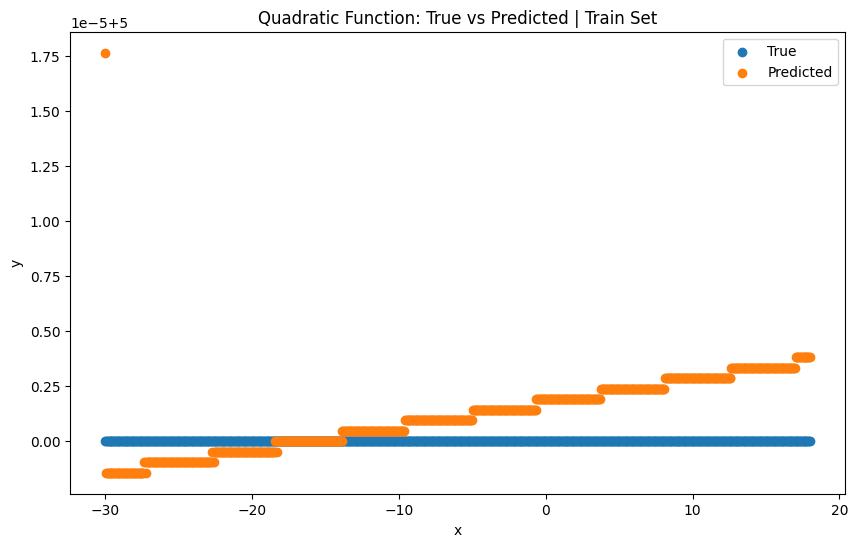

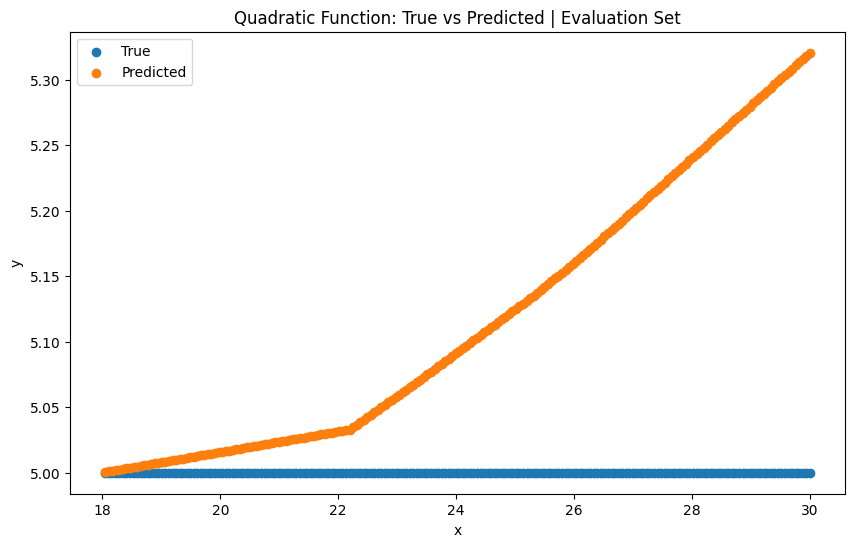

In [7]:
# Generate and normalize data
train_x, train_y, eval_x, eval_y = generate_data()
train_x_normalized, train_y_normalized, scaler_x, scaler_y = normalize_data(train_x, train_y)
eval_x_normalized, eval_y_normalized = scale_data(eval_x, eval_y, scaler_x, scaler_y)

# Create dataloaders
train_dataloader = create_dataloader(train_x_normalized, train_y_normalized)

# Initialize and train model
# model = QuadraticNet([1, 32, 32, 1])
model = ICNN([1, 8, 8, 1])
trained_model = train_model(model, train_dataloader)

# Evaluate model on train set
train_y_pred = evaluate_model(trained_model, train_x_normalized, scaler_y)

# Evaluate model on evaluation set
eval_y_pred = evaluate_model(trained_model, eval_x_normalized, scaler_y)

# Plot results
plot_results(train_x, train_y, train_y_pred, "Train Set")
plot_results(eval_x, eval_y, eval_y_pred, "Evaluation Set")